## Mini Project

In [88]:
import torch
import time
import numpy as np

### Load Dataset - MNIST

In [89]:
import torchvision
import torchvision.transforms as transforms

In [90]:
batch_size=100

transform = transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [91]:
len(trainset),len(testset)

(60000, 10000)

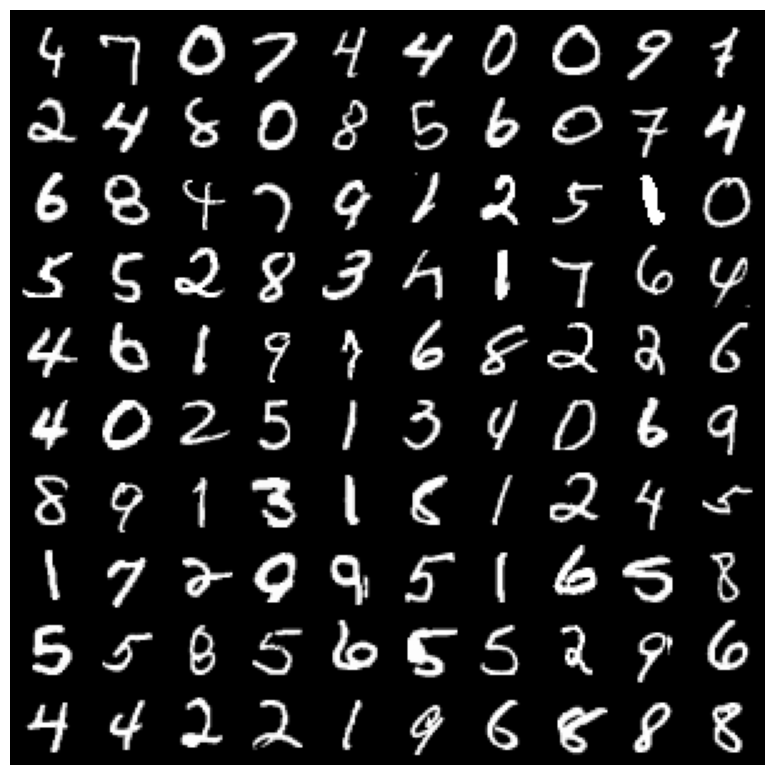

In [92]:
import matplotlib.pyplot as plt

dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[:100,:,:,:]
images = images / 2 + 0.5
plt.figure(figsize=(10,10),dpi=100)
plt.imshow(np.transpose(torchvision.utils.make_grid(images,nrow=10).numpy(),(1,2,0)))
plt.axis('off')
plt.show()

## Feature Extraction - scattering net

### scattering net with known invariants

In [93]:
from kymatio import Scattering2D

scattering = Scattering2D(J=2, shape=(28, 28), max_order=1)
K = 17 # 1st order

# scattering = Scattering2D(J=2, shape=(28, 28), max_order=2)
# K = 81 # 2nd order

scattering = scattering.cuda()

d:\program\python\lib\site-packages\kymatio\frontend\entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


In [94]:
Sdata = np.zeros((len(trainset),833)) # 17*7*7
# Sdata = np.zeros((len(trainset),3969)) # 81*7*7

Slabel = np.zeros((len(trainset),1))
Sdata.shape, Slabel.shape

((60000, 833), (60000, 1))

In [95]:
start = time.time()

for batch_idx, (data, target) in enumerate(trainloader):
    print(batch_idx,end=',')
    data = data.to('cuda')
    sdata = scattering(data)
    Sdata[batch_size*batch_idx:(batch_idx+1)*batch_size,:] = sdata.to('cpu').numpy().reshape(batch_size,-1)
    Slabel[batch_size*batch_idx:(batch_idx+1)*batch_size,:] = target.numpy().reshape(batch_size,-1)
    
end = time.time()
end - start

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

12.224631309509277

In [96]:
test = scattering(data).to('cpu').numpy()[0]

In [97]:
test.shape

(1, 17, 7, 7)

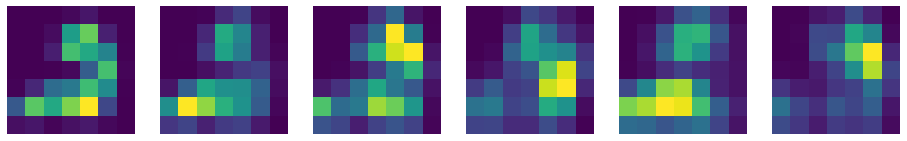

In [17]:
plt.figure(figsize=(16,2.5))
plt.subplot(161)
plt.imshow(test[0,0,:,:])
plt.axis('off')
plt.subplot(162)
plt.imshow(test[0,3,:,:])
plt.axis('off')
plt.subplot(163)
plt.imshow(test[0,6,:,:])
plt.axis('off')
plt.subplot(164)
plt.imshow(test[0,9,:,:])
plt.axis('off')
plt.subplot(165)
plt.imshow(test[0,12,:,:])
plt.axis('off')
plt.subplot(166)
plt.imshow(test[0,15,:,:])
plt.axis('off')
plt.show()

## Visualize

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.style as style 
import matplotlib.pyplot as plt
import matplotlib

In [130]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### PCA of scattering net

In [131]:
start = time.time()

Sdata_pca_embedded = PCA(n_components=2).fit_transform(Sdata)  
Sdata_pca_embedded.shape

end = time.time()
end - start

1.359938621520996

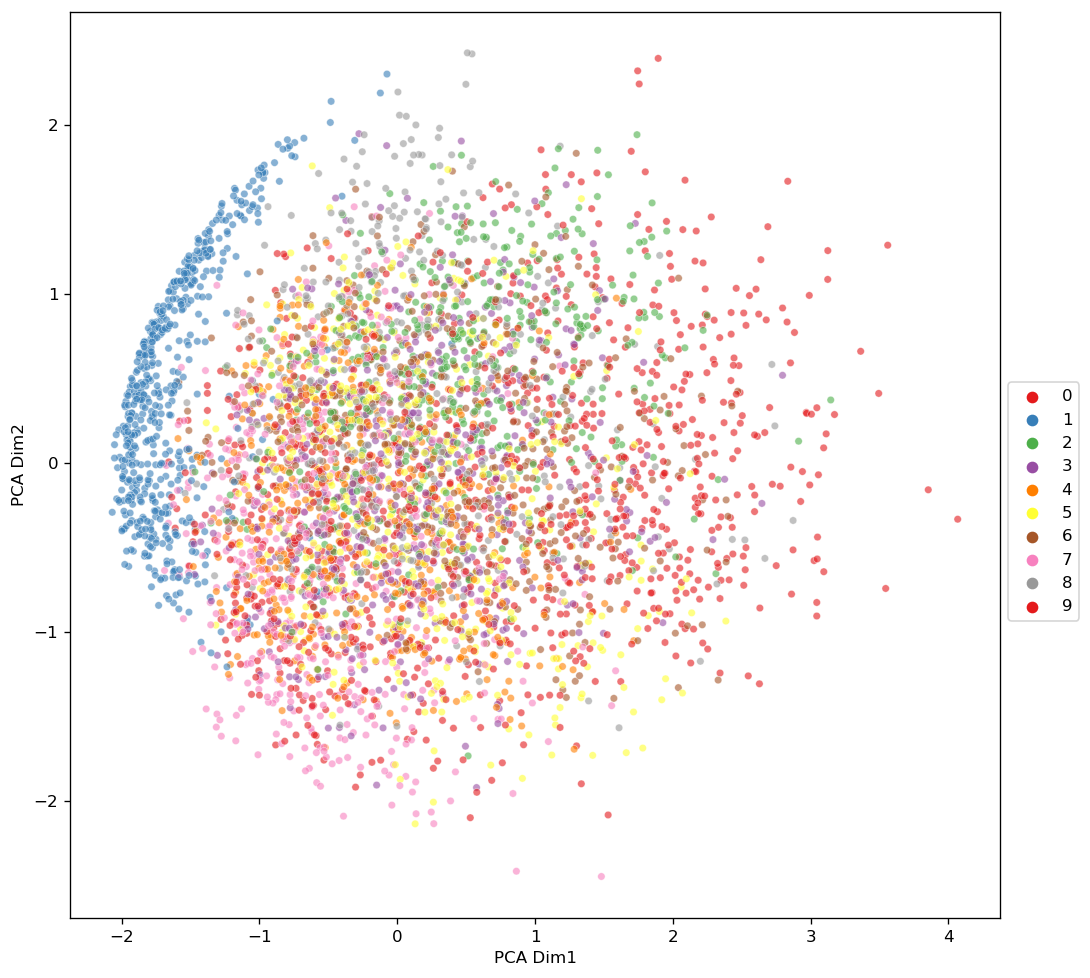

In [132]:
Sdata_pca_embedded_df = pd.DataFrame(Sdata_pca_embedded,index=Slabel)
Sdata_pca_embedded_df = Sdata_pca_embedded_df.reset_index()
Sdata_pca_embedded_df['index'] = Sdata_pca_embedded_df['index'].astype(int)
Sdata_pca_embedded_df_plot = Sdata_pca_embedded_df.loc[range(5000),:]
Sdata_pca_embedded_df_plot.columns = ['Label','PCA Dim1', 'PCA Dim2']
plt.figure(figsize=(10,10),dpi=120)
ax = sns.scatterplot(x='PCA Dim1', y='PCA Dim2',hue='Label',data=Sdata_pca_embedded_df_plot,
                     palette='Set1',alpha=0.6,s=20,legend='full') # tab10  Set1  husl 
legend = plt.legend(bbox_to_anchor=(1, 0.6))
plt.show()

### tSNE of scattering net
t-SNE(t-distributed stochastic neighbor embedding)

In [133]:
Sdata.shape

(60000, 833)

In [134]:
start = time.time()

Sdata_tsne_embedded = TSNE(n_components=2).fit_transform(Sdata)
# Sdata_tsne_embedded.shape

end = time.time()
end - start

4159.681273460388

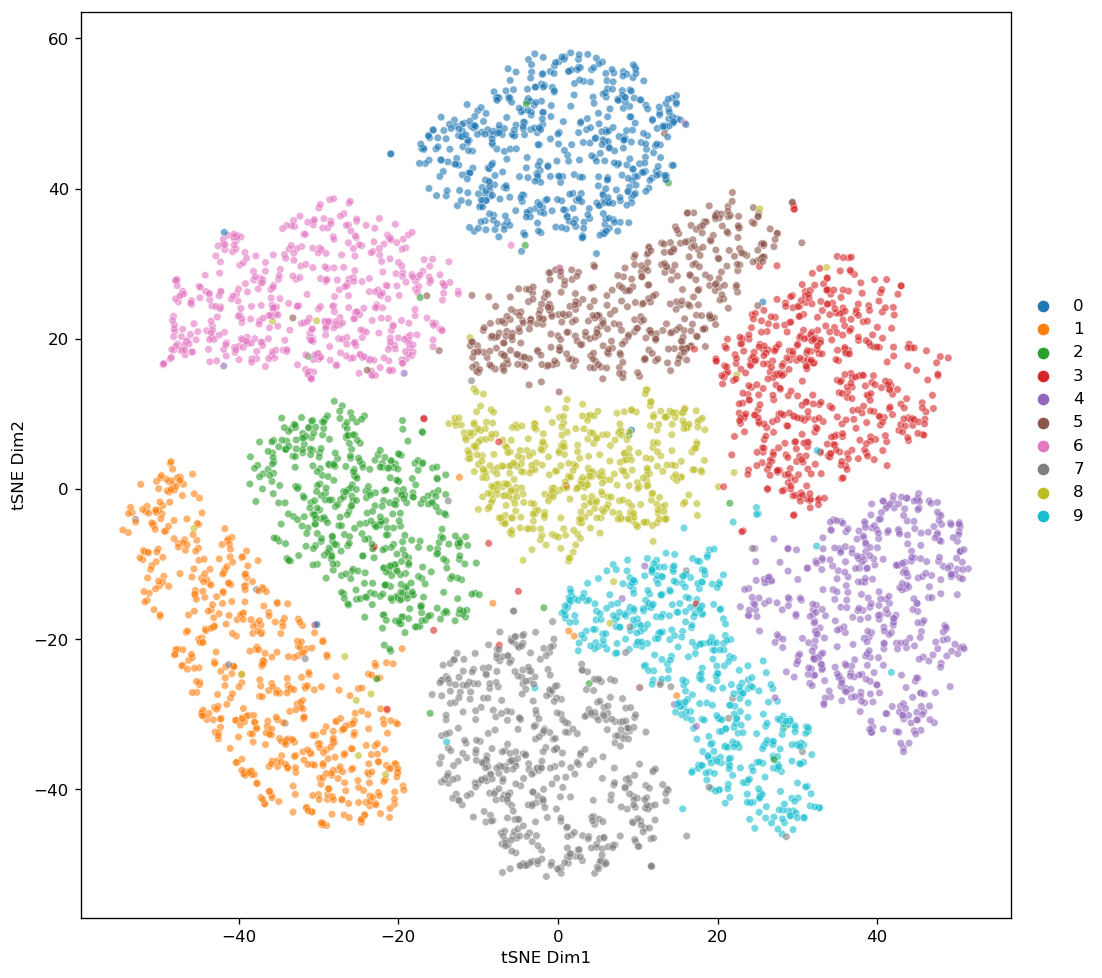

In [135]:
Sdata_tsne_embedded_df = pd.DataFrame(Sdata_tsne_embedded,index=Slabel)
Sdata_tsne_embedded_df = Sdata_tsne_embedded_df.reset_index()
Sdata_tsne_embedded_df['index'] = Sdata_tsne_embedded_df['index'].astype(int)
Sdata_tsne_embedded_df_plot = Sdata_tsne_embedded_df.loc[range(5000),:]
Sdata_tsne_embedded_df_plot.columns = ['Label','tSNE Dim1', 'tSNE Dim2']
plt.figure(figsize=(10,10),dpi=120)
ax = sns.scatterplot(x='tSNE Dim1', y='tSNE Dim2',hue='Label',data=Sdata_tsne_embedded_df_plot,
                     palette='tab10',alpha=0.6,s=20,legend='full')
legend = plt.legend(bbox_to_anchor=(1.001, 0.7),facecolor='white',edgecolor='white')
plt.show()

### Classifications based on features extracted by scattering net

We try 4 different classification methods here.  
-- LDA (LinearDiscriminantAnalysis)  
-- Logistic Regression  
-- SVM  
-- Random Forest  

In [120]:
from sklearn.model_selection import cross_validate

In [121]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

start = time.time()

lda = LinearDiscriminantAnalysis()
# (3.6621105670928955, array([0.97090582, 0.9729973 , 0.97089709]))

lda_results = cross_validate(lda, Sdata[:10000], Slabel[:10000], cv=3, scoring='accuracy')
lda_results = lda_results['test_score']

end = time.time()
end - start, lda_results

d:\program\python\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\program\python\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\program\python\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(3.5861668586730957, array([0.97360528, 0.96939694, 0.97179718]))

In [122]:
from sklearn.linear_model import LogisticRegression

start = time.time()

logistic_regression = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
# (3.1544511318206787, array([0.97810438, 0.97209721, 0.969997  ]))
# logistic_regression = LogisticRegression(penalty = 'elasticnet',l1_ratio = 0.15,random_state=0, solver='saga')
# (190.6933810710907, array([0.9790042 , 0.969997  , 0.96879688]))

logistic_regression_results = cross_validate(logistic_regression, Sdata[:10000], Slabel[:10000], cv=3, scoring='accuracy')
logistic_regression_results = logistic_regression_results['test_score']

end = time.time()
end - start, logistic_regression_results

d:\program\python\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\program\python\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
d:\program\python\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

(3.0954530239105225, array([0.97210558, 0.97479748, 0.97749775]))

In [123]:
from sklearn import svm

start = time.time()

linear_svc = svm.LinearSVC()
# (24.275047779083252, array([0.98530294, 0.98259826, 0.9789979 ]))
# linear_svc = svm.LinearSVC(random_state=0, tol=1e-5)
# (25.60028052330017, array([0.98530294, 0.98259826, 0.9789979 ]))

svm_results = cross_validate(linear_svc, Sdata[:10000], Slabel[:10000], cv=3, scoring='accuracy')
svm_results = svm_results['test_score']

end = time.time()
end - start, svm_results

d:\program\python\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\program\python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\program\python\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\program\python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\program\python\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarni

(23.2415509223938, array([0.98080384, 0.98079808, 0.98109811]))

In [124]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()

random_forest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
# (3.6762218475341797, array([0.93041392, 0.92859286, 0.93249325]))
# random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, random_state=2)
# (17.511837482452393, array([0.89472106, 0.88178818, 0.89888989]))

random_forest_results = cross_validate(random_forest, Sdata[:10000], Slabel[:10000], cv=3, scoring='accuracy')
random_forest_results = random_forest_results['test_score']

end = time.time()
end - start, random_forest_results

d:\program\python\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\program\python\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\program\python\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


(3.67891001701355, array([0.92981404, 0.94089409, 0.939994  ]))

In [125]:
lda_results,logistic_regression_results,svm_results,random_forest_results

(array([0.97360528, 0.96939694, 0.97179718]),
 array([0.97210558, 0.97479748, 0.97749775]),
 array([0.98080384, 0.98079808, 0.98109811]),
 array([0.92981404, 0.94089409, 0.939994  ]))

In [126]:
lda_results.mean(),logistic_regression_results.mean(),svm_results.mean(),random_forest_results.mean()

(0.9715997994520508,
 0.9748002694690584,
 0.9809000096170385,
 0.9369007086671474)

In [127]:
lda_results.std(),logistic_regression_results.std(),svm_results.std(),random_forest_results.std()

(0.0017237070590856256,
 0.00220134543187911,
 0.0001400977227313791,
 0.00502448836185395)